In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy

In [2]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [3]:
def poly(x, *par):
    return np.polyval(par,x)

In [4]:
def constant(x, *par):
    return 0

In [5]:
def log(x, *par):
    return par[0]*np.log(x)

In [6]:
def sin(x, *par):
    return par[0]*np.cos(par[1]*x + par[2])

In [7]:
poly(3,1,2,3)

18

In [8]:
def gp_regression(x_train, y_train, mean_func, init_param, **kwargs):
    kernel = GPy.kern.RBF(1)


    res = scipy.optimize.curve_fit(mean_func,  np.ravel(x_train), np.ravel(y_train), p0=init_param)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_func(x, *par)
    mf.update_gradients = lambda a,b: None

    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()

    start, end = 1940, 2031
    start_align = np.min(x_train)-start
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]

    validate_rmse = mean_squared_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate], squared=False)
    validate_mae = mean_absolute_error(y_val, y_mean[train_up+start_align:train_up+start_align+validate])
    test_rmse = mean_squared_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test], squared=False)
    test_mae = mean_absolute_error(y_test, y_mean[train_up+start_align+validate:train_up+start_align+validate+test])
    txt = f"""validate rmse : {validate_rmse} \n validate mae : {validate_mae} \n
    test rmse : {test_rmse} \n test mae : {test_mae}"""


    model.plot(plot_limits=[start, end])

    plt.title('Age ' + str(age) + f" {mean_func.__name__}")
    plt.xlabel('Year')
    plt.ylabel('Mortality Rate' )
    plt.scatter(x_train,y_train, marker="x", color='black', label="data")
    plt.scatter(x_val,y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.figtext(0.5, 0.2, txt, wrap=True, horizontalalignment='center', fontsize=12)
    plt.ylim([0.1,0.35])

    plt.grid(True)
#     plt.savefig(f'./{IMG_DIR}/{mean_func.__name__}_{age}_mf.png')
    plt.show()
    
    return par

In [9]:
CSV_FIlE = "../japan3.csv"
df = pd.read_csv(CSV_FIlE)
age = 90
df_all = {}
df_all[age]= df[(df["age"]==age)]

year = df_all[age]["year"].to_numpy().reshape(-1,1)
rate = df_all[age]["rate"].to_numpy().reshape(-1,1)

In [10]:
train_ratio, validate_ratio, test_ratio = 0.8, 0.1, 0.1
length = len(rate)

train, validate, test = int(train_ratio*length), int(validate_ratio*length), int(test_ratio*length)
train_up, train_low = train, train-train

In [11]:
x_train, y_train = year[train_low:train_up],rate[train_low:train_up]
x_val, y_val = year[train_up:train_up+validate],rate[train_up:train_up+validate]
x_test, y_test = year[train_up+validate:],rate[train_up+validate:]

params:[ 6.14631139e+07 -9.80679944e-03]


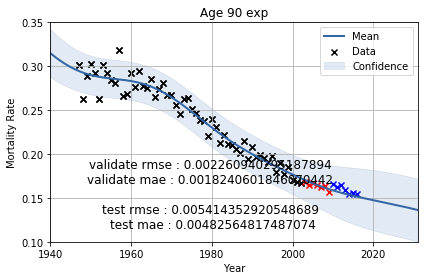

array([ 6.14631139e+07, -9.80679944e-03])

In [12]:
gp_regression(x_train, y_train, exp, (1, -0.001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[0.03192874]


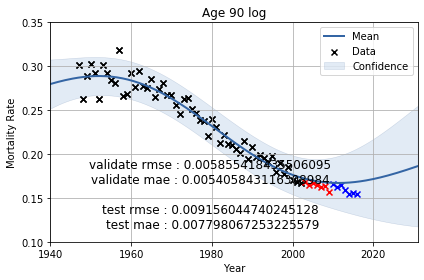

array([0.03192874])

In [13]:
gp_regression(x_train, y_train, log, (0.0001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[ 1.15631290e-07 -1.11170832e-03  4.27211066e+00 -8.20205983e+03
  7.86707526e+06 -3.01566474e+09]


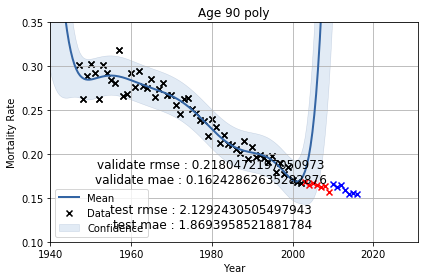

array([ 1.15631290e-07, -1.11170832e-03,  4.27211066e+00, -8.20205983e+03,
        7.86707526e+06, -3.01566474e+09])

In [14]:
gp_regression(x_train, y_train, poly, (0.1, 0.1, 1,1,1,1),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[-2.45027462e-03  5.08038669e+00]


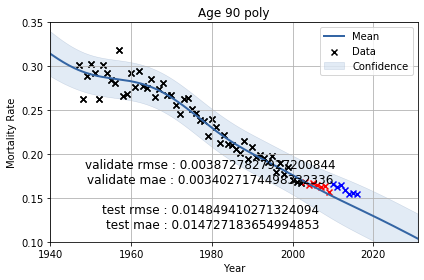

array([-2.45027462e-03,  5.08038669e+00])

In [15]:
gp_regression(x_train, y_train, poly, (0.001, 0.001,),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

params:[ 1.42865261e-06 -8.49092932e-03  1.68181075e+01 -1.11015432e+04]


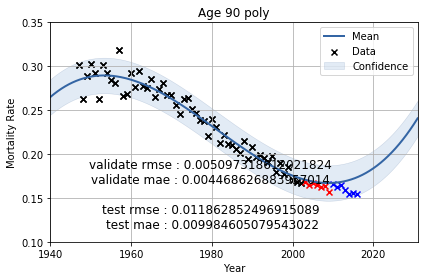

array([ 1.42865261e-06, -8.49092932e-03,  1.68181075e+01, -1.11015432e+04])

In [16]:
gp_regression(x_train, y_train, poly, (0.1, 0.1, 0.1, 0.001),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )

 /home/chen/work/venv/lib/python3.6/site-packages/scipy/optimize/minpack.py:829: OptimizeWarning:Covariance of the parameters could not be estimated


params:[1.]


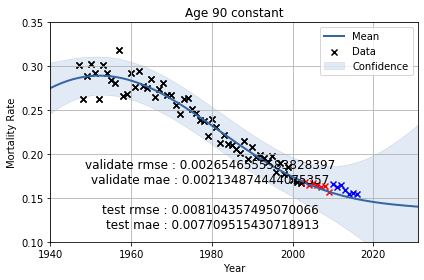

array([1.])

In [20]:
gp_regression(x_train, y_train, constant, (1),
                    x_val=x_val,y_val=y_val,
                    x_test=x_test,y_test=y_test
             )